In [1]:
!pip install wget
import os
import torch
import pandas as pd
import numpy as np
import torch
from torch import nn


ssh_config = """
Host github.com
  IdentityFile ~/.ssh/github.pem
  User davipeag
  StrictHostKeyChecking no
"""

if os.name == 'nt':
  base_path = ""
  REPO_DIR = "."
  STORE_DIR ="." 
  print("Windows")
else:
  print("Unix-like")
  REPO_DIR = "/tmp/HeartRateRegression"
  from google.colab import drive, auth
  drive.mount('/content/drive')
  GIT_PATH = "/content/drive/My\ Drive/deeplearning_project/github.pem"
  DATA_DIR = os.path.join(REPO_DIR, "repo")
  STORE_DIR ="/content/drive/My Drive/deeplearning_project/" 
  !mkdir ~/.ssh
  !cp -u {GIT_PATH} ~/.ssh/
  !chmod u=rw,g=,o= ~/.ssh/github.pem
  !echo "{ssh_config}" > ~/.ssh/config
  !chmod u=rw,g=,o= ~/.ssh/config
  ! (cd /tmp && git clone git@github.com:davipeag/HeartRateRegression.git)
  ! (cd {REPO_DIR} && git pull )
  import sys
  sys.path.append(REPO_DIR)

def git_pull():
  ! (cd {REPO_DIR} && git pull )

git_pull()

Unix-like
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘/root/.ssh’: File exists
fatal: destination path 'HeartRateRegression' already exists and is not an empty directory.
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 9 (delta 5), reused 6 (delta 3), pack-reused 0
Unpacking objects: 100% (9/9), done.
From github.com:davipeag/HeartRateRegression
   08c8301..ddaf3ae  master     -> origin/master
Updating 08c8301..ddaf3ae
Fast-forward
 CustomTrainers/FullTrainers.py |   3 ++
 pamap_deepconvlstm.ipynb       | 118 +++++++++++++++++++++--------------------
 2 files changed, 64 insertions(+), 57 deletions(-)
Already up to date.


In [2]:
import random
import torch
from torch import nn
import numpy as np
args = {
    'epoch_num': 250,     # Number of epochs.
    'lr': 1.0e-3,           # Learning rate.
    'weight_decay': 10e-4, # L2 penalty.
    'momentum': 0.9,      # Momentum.
    'num_workers': 0,     # Number of workers on data loader.
    'batch_size': 128,     # Mini-batch size. 128
    'batch_test': 248,     # size of test batch
    'window': 15,
    'initial_window':5,
    'clip_norm': 6.0,     # Upper limit on gradient L2 norm ###
}
if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

SEED = 1234
def reset_seeds():
  random.seed(SEED)
  np.random.seed(SEED)
  torch.manual_seed(SEED)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  torch.cuda.manual_seed(SEED)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

reset_seeds()

cuda


In [3]:
from data_utils import (PpgDaliaExtractor, FormatPPGDalia)

extractor = PpgDaliaExtractor(DATA_DIR)
ppg_dalia_formatter = FormatPPGDalia()
dfs_train = [ppg_dalia_formatter.transform(extractor.extract_subject(i)) for i in range(1,16)]
# [len(df)//32 for df in dfs_train_dalia]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """


In [4]:
git_pull()

import importlib

import PPG
import preprocessing_utils
from PPG import FullTrainer
import RegressionHR

from RegressionHR import FullTrainer
from RegressionHR import PceLstmDefaults
from RegressionHR import PceLstmModel
from RegressionHR import TrainerJoint
from RegressionHR import  UtilitiesData
import Models
from  Models.BaseModels import ConstantHiddenSizeHalvingFullyConvolutionalEncoder1D
from Models import TimeSnippetModels

import PreprocessingHelpers

import Constants
from Constants import DatasetMapping


import Trainer
from  Trainer import BatchTrainers
from Trainer import BatchComputers
from Trainer import Interfaces

import CustomTrainers
from CustomTrainers import  DeepConvLstmFullTrainer
from CustomTrainers import SpecificTrainers, FullTrainers
importlib.reload(CustomTrainers)
importlib.reload(CustomTrainers.SpecificTrainers)
importlib.reload(CustomTrainers.FullTrainers)
import PreprocessingHelpers.TransformerGetters
                            
from PreprocessingHelpers import TransformerGetters

importlib.reload(Constants.DatasetMapping)

importlib.reload(PreprocessingHelpers)
importlib.reload(PreprocessingHelpers.TransformerGetters)
# importlib.reload(PPG.AttentionDefaults)
importlib.reload(PPG)
# importlib.reload(PPG.UtilitiesDataXY)
importlib.reload(PPG.Models)
importlib.reload(Models.BaseModels)
importlib.reload(Models.TimeSnippetModels)
# importlib.reload(PPG.NoHrPceLstmModel)
# importlib.reload(PPG.TrainerXY)
# importlib.reload(PPG.TrainerIS)
# importlib.reload(PPG.FullTrainer)
# importlib.reload(PceLstmDefaults)
# importlib.reload(preprocessing_utils)
importlib.reload(RegressionHR)
importlib.reload(RegressionHR.FullTrainer)
importlib.reload(RegressionHR.PceLstmDefaults)
importlib.reload(PPG.UtilitiesDataXY)
importlib.reload(preprocessing_utils)
importlib.reload(RegressionHR.TrainerJoint)
importlib.reload(RegressionHR.UtilitiesData)
importlib.reload(RegressionHR.PceLstmModel)
importlib.reload(preprocessing_utils)

importlib.reload(Trainer)
importlib.reload(Trainer.BatchTrainers)
importlib.reload(Trainer.BatchComputers)
importlib.reload(Trainer.ToolBox)
importlib.reload(Trainer.Interfaces )
# import imp
# for module in sys.modules.values():
#     importlib.reload(module)

Already up to date.


<module 'Trainer.Interfaces' from '/tmp/HeartRateRegression/Trainer/Interfaces.py'>

In [11]:
import matplotlib.pyplot as plt
import pickle

def compute_ensemble(results):
  
  ys = [v["predictions"][0].reshape(-1).numpy() for v in results]
  min_len_y = min([len(y) for y in ys])
  ys = [y[:min_len_y] for y in ys]
  for i in range(1, len(ys)-1):
    # assert np.all(ys[i] == ys[i-1])
    assert np.all(np.abs(ys[i] - ys[i-1])<1)
  ps = np.stack([v["predictions"][1].reshape(-1).numpy()[:min_len_y] for v in results])

  s = ps[0]
  for p in ps[1:]:
    s = s + p

  a = s/len(ps)
  y = ys[0]

  plt.figure()
  plt.plot(a)
  plt.plot(y)
  plt.show()

  return np.mean(np.abs(a - y)), np.mean(np.abs(ps - y))


def compute_ensemble_named(results, model_name="PceLstm"):
  
  # results = [r[model_name] for r in results]

  ys = [v["labels"].reshape(-1) for v in results]
  min_len_y = min([len(y) for y in ys])
  ys = [y[:min_len_y] for y in ys]
  for i in range(1, len(ys)-1):
    # assert np.all(ys[i] == ys[i-1])
    assert np.all(np.abs(ys[i] - ys[i-1])<1)
  ps = np.stack([v["predictions"].reshape(-1)[:min_len_y] for v in results])

  s = ps[0]
  for p in ps[1:]:
    s = s + p

  a = s/len(ps)
  y = ys[0]

  plt.figure()
  plt.plot(a)
  plt.plot(y)
  plt.show()

  return np.mean(np.abs(a - y)), np.mean(np.abs(ps - y))

# compute_ensemble_named(aresults[0].values())

{'frequency_hz': 32, 'net_args': {'feature_count': 7, 'ts_per_is': 12, 'period_seconds': 3, 'ts_per_window': 50, 'frequency_hz': 32}, 'period_s': 3, 'ts_per_is': 12, 'ts_per_window': 50, 'ts_sub': 0, 'batch_size': 16, 'weight_decay': 0.0001, 'lr': 0.001, 'feature_count': 7, 'period_seconds': 3} 9.336137


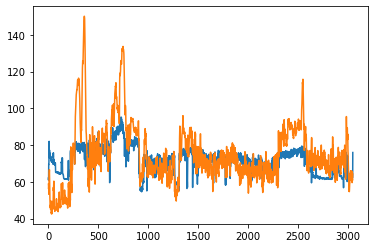

0-TS:(9.336137, 9.336137)
best val epoch: 1
[1/25]: loss_train: [15.306786] loss_val [16.466974] loss_ts [7.135686]
best val epoch: 2
[2/25]: loss_train: [14.701415] loss_val [15.357413] loss_ts [7.205712]
best val epoch: 4
[4/25]: loss_train: [14.241467] loss_val [14.542624] loss_ts [8.485568]
best val epoch: 6
[6/25]: loss_train: [13.631664] loss_val [13.947287] loss_ts [9.353493]
best val epoch: 9
[9/25]: loss_train: [12.926898] loss_val [13.813869] loss_ts [7.788357]
best val epoch: 11
[11/25]: loss_train: [10.4705925] loss_val [12.063417] loss_ts [7.9447722]
best val epoch: 13
[13/25]: loss_train: [9.135657] loss_val [10.590013] loss_ts [10.357966]
best val epoch: 14
[14/25]: loss_train: [8.796691] loss_val [10.186384] loss_ts [9.989563]
best val epoch: 15
[15/25]: loss_train: [8.130517] loss_val [9.501674] loss_ts [7.692622]
best val epoch: 17
[17/25]: loss_train: [8.057397] loss_val [9.171669] loss_ts [8.300126]
best val epoch: 18
[18/25]: loss_train: [7.990842] loss_val [9.1365

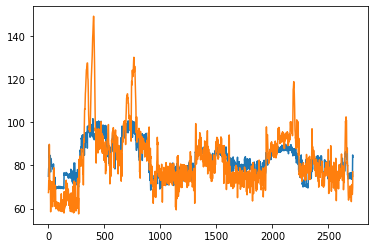

1-TS:(6.5340695, 6.5340695)
best val epoch: 1
[1/25]: loss_train: [16.005337] loss_val [12.293488] loss_ts [10.700183]
best val epoch: 3
[3/25]: loss_train: [14.822236] loss_val [12.21314] loss_ts [10.435606]
best val epoch: 4
[4/25]: loss_train: [15.118796] loss_val [11.910145] loss_ts [10.82025]
best val epoch: 7
[7/25]: loss_train: [13.934089] loss_val [11.548601] loss_ts [10.158547]
best val epoch: 10
[10/25]: loss_train: [10.646665] loss_val [9.45195] loss_ts [14.514922]
best val epoch: 11
[11/25]: loss_train: [9.075919] loss_val [7.645718] loss_ts [13.294892]
best val epoch: 14
[14/25]: loss_train: [7.988277] loss_val [7.4582467] loss_ts [17.272137]
best val epoch: 16
[16/25]: loss_train: [7.7703185] loss_val [7.45711] loss_ts [16.582346]
best val epoch: 18
[18/25]: loss_train: [7.834855] loss_val [7.0676093] loss_ts [19.204945]
best val epoch: 19
[19/25]: loss_train: [8.063824] loss_val [7.0035267] loss_ts [15.888805]
best val epoch: 20
[20/25]: loss_train: [7.0916514] loss_val 

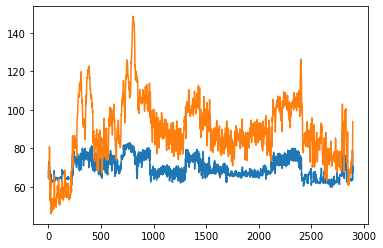

2-TS:(20.70462, 20.70462)
best val epoch: 1
[1/25]: loss_train: [17.074713] loss_val [17.562038] loss_ts [11.2173605]
best val epoch: 2
[2/25]: loss_train: [14.8904295] loss_val [15.294023] loss_ts [9.643963]
best val epoch: 3
[3/25]: loss_train: [14.356425] loss_val [14.650121] loss_ts [9.080597]
best val epoch: 6
[6/25]: loss_train: [13.9454975] loss_val [13.974024] loss_ts [9.486701]
best val epoch: 9
[9/25]: loss_train: [13.603834] loss_val [13.70144] loss_ts [8.781727]
best val epoch: 10
[10/25]: loss_train: [13.079455] loss_val [12.874798] loss_ts [9.033575]
best val epoch: 12
[12/25]: loss_train: [10.294328] loss_val [10.437113] loss_ts [8.636159]
best val epoch: 13
[13/25]: loss_train: [10.04116] loss_val [10.084039] loss_ts [9.809664]
best val epoch: 15
[15/25]: loss_train: [8.897511] loss_val [9.3066635] loss_ts [8.25635]
best val epoch: 16
[16/25]: loss_train: [8.925464] loss_val [9.302314] loss_ts [12.196749]
best val epoch: 17
[17/25]: loss_train: [8.05198] loss_val [8.275

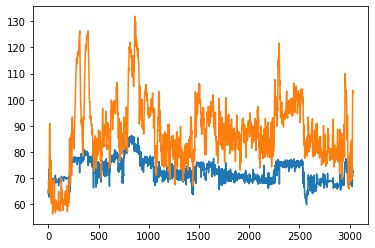

3-TS:(16.380081, 16.380081)
best val epoch: 1
[1/25]: loss_train: [12.858503] loss_val [13.1434] loss_ts [45.713207]
best val epoch: 2
[2/25]: loss_train: [11.860864] loss_val [12.112501] loss_ts [41.274582]
best val epoch: 7
[7/25]: loss_train: [11.164761] loss_val [11.497699] loss_ts [46.650463]
best val epoch: 9
[9/25]: loss_train: [10.535253] loss_val [11.126812] loss_ts [44.1449]
best val epoch: 10
[10/25]: loss_train: [10.244854] loss_val [10.801855] loss_ts [46.447277]
best val epoch: 11
[11/25]: loss_train: [9.383536] loss_val [10.093901] loss_ts [48.706448]
best val epoch: 12
[12/25]: loss_train: [8.688841] loss_val [9.3176565] loss_ts [44.55804]
best val epoch: 13
[13/25]: loss_train: [8.468638] loss_val [9.026671] loss_ts [43.508713]
best val epoch: 15
[15/25]: loss_train: [7.983948] loss_val [7.989432] loss_ts [47.01219]
best val epoch: 17
[17/25]: loss_train: [7.628939] loss_val [7.809065] loss_ts [44.584995]
best val epoch: 19
[19/25]: loss_train: [7.0543704] loss_val [7.

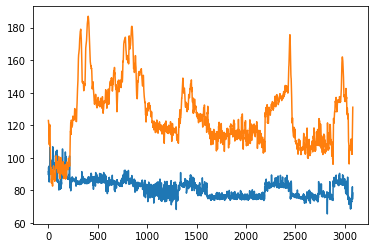

4-TS:(44.77329, 44.77329)
best val epoch: 1
[1/25]: loss_train: [14.649355] loss_val [13.8278265] loss_ts [37.845974]
best val epoch: 3
[3/25]: loss_train: [13.996] loss_val [13.088567] loss_ts [34.65227]
best val epoch: 4
[4/25]: loss_train: [13.332033] loss_val [12.389864] loss_ts [38.27411]
best val epoch: 5
[5/25]: loss_train: [13.144228] loss_val [12.324805] loss_ts [38.282703]
best val epoch: 6
[6/25]: loss_train: [12.987691] loss_val [12.075916] loss_ts [35.3228]
best val epoch: 7
[7/25]: loss_train: [12.869121] loss_val [11.990466] loss_ts [31.640354]
best val epoch: 8
[8/25]: loss_train: [12.919007] loss_val [11.800905] loss_ts [37.383297]
best val epoch: 9
[9/25]: loss_train: [12.191177] loss_val [11.200906] loss_ts [38.827953]
best val epoch: 10
[10/25]: loss_train: [10.85932] loss_val [9.569139] loss_ts [27.570005]
best val epoch: 11
[11/25]: loss_train: [9.580565] loss_val [8.666523] loss_ts [42.751125]
best val epoch: 12
[12/25]: loss_train: [9.03234] loss_val [8.272175] 

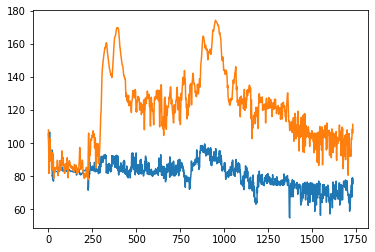

5-TS:(38.893032, 38.893032)
best val epoch: 1
[1/25]: loss_train: [14.638575] loss_val [14.624556] loss_ts [9.667196]
best val epoch: 2
[2/25]: loss_train: [14.497395] loss_val [14.518128] loss_ts [10.15548]
best val epoch: 4
[4/25]: loss_train: [13.997498] loss_val [14.147504] loss_ts [10.124378]
best val epoch: 5
[5/25]: loss_train: [13.981714] loss_val [14.0817585] loss_ts [12.486612]
best val epoch: 6
[6/25]: loss_train: [13.765529] loss_val [13.998122] loss_ts [10.88168]
best val epoch: 7
[7/25]: loss_train: [13.416126] loss_val [13.872638] loss_ts [9.461095]
best val epoch: 9
[9/25]: loss_train: [12.435564] loss_val [13.164806] loss_ts [10.631401]
best val epoch: 10
[10/25]: loss_train: [11.032704] loss_val [11.1312895] loss_ts [12.066196]
best val epoch: 11
[11/25]: loss_train: [9.618737] loss_val [9.675535] loss_ts [11.531707]
best val epoch: 12
[12/25]: loss_train: [8.347287] loss_val [8.35186] loss_ts [15.172313]
best val epoch: 15
[15/25]: loss_train: [7.6488047] loss_val [8

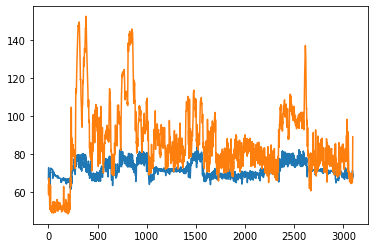

6-TS:(17.19469, 17.19469)
best val epoch: 1
[1/25]: loss_train: [15.275686] loss_val [14.89522] loss_ts [11.952731]
best val epoch: 3
[3/25]: loss_train: [14.097268] loss_val [14.881343] loss_ts [12.379123]
best val epoch: 4
[4/25]: loss_train: [13.549879] loss_val [14.0052] loss_ts [12.989464]
best val epoch: 5
[5/25]: loss_train: [13.376502] loss_val [13.408578] loss_ts [17.293823]
best val epoch: 6
[6/25]: loss_train: [12.328085] loss_val [13.101684] loss_ts [20.5131]
best val epoch: 9
[9/25]: loss_train: [9.53316] loss_val [10.758403] loss_ts [22.434698]
best val epoch: 10
[10/25]: loss_train: [9.257762] loss_val [9.369935] loss_ts [18.03297]
best val epoch: 14
[14/25]: loss_train: [8.438381] loss_val [8.659935] loss_ts [9.452924]
best val epoch: 15
[15/25]: loss_train: [7.5895457] loss_val [8.030844] loss_ts [12.097968]
best val epoch: 16
[16/25]: loss_train: [7.587403] loss_val [7.6002345] loss_ts [9.936331]
Final: [9.936331]
{'frequency_hz': 32, 'net_args': {'feature_count': 7, 

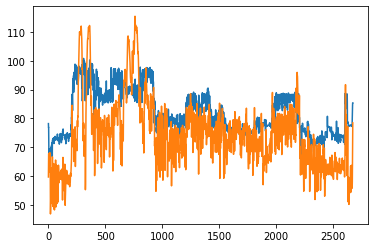

7-TS:(9.936331, 9.936331)
best val epoch: 1
[1/25]: loss_train: [16.036924] loss_val [17.063019] loss_ts [11.689313]
best val epoch: 2
[2/25]: loss_train: [14.319263] loss_val [15.460853] loss_ts [8.917861]
best val epoch: 4
[4/25]: loss_train: [14.002121] loss_val [15.2915] loss_ts [9.077323]
best val epoch: 5
[5/25]: loss_train: [13.883171] loss_val [15.279022] loss_ts [9.058306]
best val epoch: 6
[6/25]: loss_train: [13.67911] loss_val [15.047978] loss_ts [9.139089]
best val epoch: 11
[11/25]: loss_train: [13.1291485] loss_val [14.73688] loss_ts [9.273859]
best val epoch: 13
[13/25]: loss_train: [12.586498] loss_val [14.462957] loss_ts [9.707263]
best val epoch: 14
[14/25]: loss_train: [12.381691] loss_val [13.814043] loss_ts [8.759982]
best val epoch: 15
[15/25]: loss_train: [10.440526] loss_val [12.468269] loss_ts [12.04769]
best val epoch: 16
[16/25]: loss_train: [9.582235] loss_val [10.21131] loss_ts [12.038107]
best val epoch: 17
[17/25]: loss_train: [8.587301] loss_val [9.4043

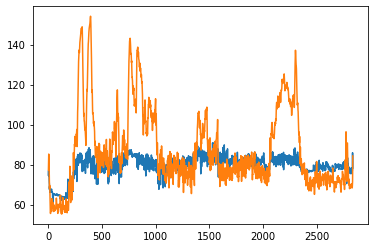

8-TS:(12.93977, 12.93977)
best val epoch: 1
[1/25]: loss_train: [17.326519] loss_val [15.026027] loss_ts [13.268248]
best val epoch: 2
[2/25]: loss_train: [15.677266] loss_val [13.754306] loss_ts [10.901034]
best val epoch: 3
[3/25]: loss_train: [14.85306] loss_val [13.406035] loss_ts [10.262215]
best val epoch: 5
[5/25]: loss_train: [13.978332] loss_val [13.139433] loss_ts [9.936875]
best val epoch: 8
[8/25]: loss_train: [13.624976] loss_val [12.982191] loss_ts [9.4617605]
best val epoch: 9
[9/25]: loss_train: [12.977297] loss_val [12.186542] loss_ts [8.625926]
best val epoch: 10
[10/25]: loss_train: [10.715278] loss_val [10.252494] loss_ts [9.744844]
best val epoch: 11
[11/25]: loss_train: [9.993998] loss_val [9.830156] loss_ts [13.654796]
best val epoch: 12
[12/25]: loss_train: [9.201572] loss_val [9.253275] loss_ts [10.150114]
best val epoch: 13
[13/25]: loss_train: [8.910112] loss_val [8.438738] loss_ts [12.4714775]
best val epoch: 18
[18/25]: loss_train: [8.629246] loss_val [8.35

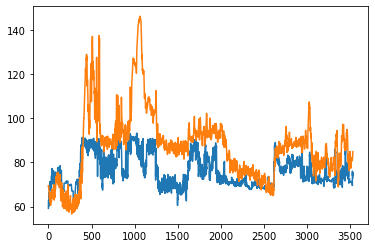

9-TS:(13.042427, 13.042427)
best val epoch: 1
[1/25]: loss_train: [15.027125] loss_val [16.127186] loss_ts [25.31777]
best val epoch: 2
[2/25]: loss_train: [13.737198] loss_val [14.752227] loss_ts [20.202381]
best val epoch: 4
[4/25]: loss_train: [13.069837] loss_val [14.319143] loss_ts [19.796602]
best val epoch: 5
[5/25]: loss_train: [13.076482] loss_val [14.281054] loss_ts [18.084839]
best val epoch: 9
[9/25]: loss_train: [12.4326725] loss_val [13.773787] loss_ts [19.798435]
best val epoch: 10
[10/25]: loss_train: [11.309456] loss_val [12.466075] loss_ts [18.731718]
best val epoch: 11
[11/25]: loss_train: [10.944634] loss_val [12.304074] loss_ts [25.770811]
best val epoch: 13
[13/25]: loss_train: [11.001434] loss_val [12.003564] loss_ts [29.093449]
best val epoch: 14
[14/25]: loss_train: [8.797403] loss_val [9.841772] loss_ts [27.258139]
best val epoch: 15
[15/25]: loss_train: [7.8193755] loss_val [8.996996] loss_ts [27.788498]
best val epoch: 16
[16/25]: loss_train: [7.7538915] los

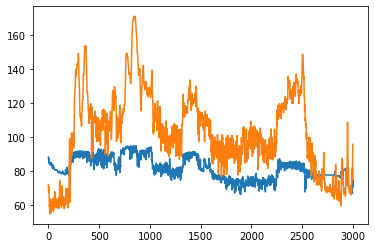

10-TS:(24.975096, 24.975096)
best val epoch: 1
[1/25]: loss_train: [16.310661] loss_val [18.614689] loss_ts [12.854073]
best val epoch: 2
[2/25]: loss_train: [14.0627] loss_val [15.772022] loss_ts [15.39309]
best val epoch: 3
[3/25]: loss_train: [13.950162] loss_val [15.667325] loss_ts [15.87647]
best val epoch: 4
[4/25]: loss_train: [13.775912] loss_val [15.42496] loss_ts [17.827215]
best val epoch: 5
[5/25]: loss_train: [13.285622] loss_val [14.845659] loss_ts [16.908709]
best val epoch: 6
[6/25]: loss_train: [13.219243] loss_val [14.134179] loss_ts [20.703133]
best val epoch: 9
[9/25]: loss_train: [12.75469] loss_val [13.812071] loss_ts [21.60118]
best val epoch: 10
[10/25]: loss_train: [12.537536] loss_val [13.704816] loss_ts [21.245739]
best val epoch: 14
[14/25]: loss_train: [11.634343] loss_val [12.507179] loss_ts [23.338934]
best val epoch: 15
[15/25]: loss_train: [10.181795] loss_val [11.458427] loss_ts [13.83483]
best val epoch: 20
[20/25]: loss_train: [9.37392] loss_val [10.

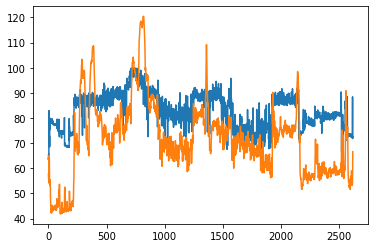

11-TS:(13.757476, 13.757476)
best val epoch: 1
[1/25]: loss_train: [15.103496] loss_val [14.579449] loss_ts [13.300133]
best val epoch: 2
[2/25]: loss_train: [14.925357] loss_val [14.3313675] loss_ts [13.160212]
best val epoch: 4
[4/25]: loss_train: [14.551506] loss_val [13.849451] loss_ts [13.169772]
best val epoch: 5
[5/25]: loss_train: [13.71642] loss_val [13.145182] loss_ts [12.191312]
best val epoch: 6
[6/25]: loss_train: [13.418767] loss_val [12.924748] loss_ts [11.231787]
best val epoch: 10
[10/25]: loss_train: [12.580377] loss_val [12.731947] loss_ts [11.74807]
best val epoch: 11
[11/25]: loss_train: [12.307161] loss_val [11.668459] loss_ts [10.836095]
best val epoch: 13
[13/25]: loss_train: [8.96485] loss_val [9.374196] loss_ts [15.417932]
best val epoch: 15
[15/25]: loss_train: [9.055978] loss_val [9.213423] loss_ts [16.079857]
best val epoch: 17
[17/25]: loss_train: [7.6341033] loss_val [8.084725] loss_ts [14.55792]
best val epoch: 25
[25/25]: loss_train: [7.1436954] loss_va

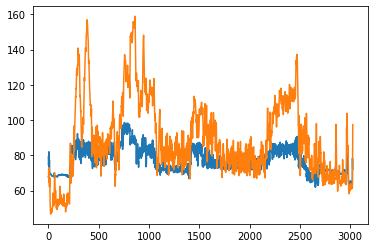

12-TS:(15.725044, 15.725044)
best val epoch: 1
[1/25]: loss_train: [16.158958] loss_val [15.76991] loss_ts [13.48789]
best val epoch: 2
[2/25]: loss_train: [14.533501] loss_val [14.352362] loss_ts [11.119592]
best val epoch: 3
[3/25]: loss_train: [14.365906] loss_val [14.345941] loss_ts [11.293912]
best val epoch: 4
[4/25]: loss_train: [14.701765] loss_val [14.280707] loss_ts [12.061412]
best val epoch: 5
[5/25]: loss_train: [13.840056] loss_val [13.745825] loss_ts [11.239099]
best val epoch: 6
[6/25]: loss_train: [13.450373] loss_val [13.542358] loss_ts [10.797729]
best val epoch: 8
[8/25]: loss_train: [12.938806] loss_val [13.255475] loss_ts [10.9609785]
best val epoch: 10
[10/25]: loss_train: [12.008334] loss_val [12.327228] loss_ts [11.506418]
best val epoch: 11
[11/25]: loss_train: [9.386184] loss_val [9.590269] loss_ts [16.975502]
best val epoch: 12
[12/25]: loss_train: [8.755496] loss_val [9.484101] loss_ts [13.181355]
best val epoch: 13
[13/25]: loss_train: [8.080282] loss_val 

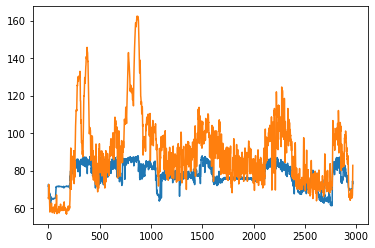

13-TS:(14.375409, 14.375409)
best val epoch: 1
[1/25]: loss_train: [17.155859] loss_val [16.276226] loss_ts [11.082359]


In [ ]:
fchoice = {
    "lr":0.001,
        "weight_decay": 0.0001,
        "batch_size": 16,
        "ts_sub": 0,
        "ts_per_window": 50,
        "ts_per_is": 12,
        "period_s": 3,
        }

discriminator_false_label = 0
from RegressionHR import FullTrainer2
import Trainer.BatchTrainers
from PPG import UtilitiesDataXY
from collections import defaultdict
import torch 
import CustomTrainers
from CustomTrainers import  DeepConvLstmFullTrainer

model_name = "DeepConvLSTM"
nepoch = 25
aresults = defaultdict(dict)
for val_sub in range(7):
  for ts_sub in range(15):
    fchoice['ts_sub'] = ts_sub
    full_trainer = DeepConvLstmFullTrainer(dfs_train, args["device"], nepoch, "dalia", model_name, frequency_hz=32)

    filename = f"dalia_deepconvlstm_{ts_sub}_{val_sub}.pkl"
    save_path = os.path.join(STORE_DIR, filename)
    try:
      with open(save_path , "rb") as f:
        out = pickle.load(f)
    except FileNotFoundError:
      out = full_trainer.train(**fchoice)
      with open(save_path, "wb") as f:
        pickle.dump(out, f)    
    print(out["args"], out['metric'])
    aresults[ts_sub][val_sub] = out
    print(f"{ts_sub}-TS:{compute_ensemble_named(list(aresults[ts_sub].values()))}")
  